In [151]:
from qiskit import *
from qiskit import Aer
import qiskit.quantum_info as qi
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import re
import csv
import time
start = time.time()

### Target state $|w>$

In [152]:
Target_state = '010'

## Setting up the The Grover operator
$$ G = U_w U_s$$
Where 
$$U_w = 2|w><w| - I$$ 
$U_w$ is a matrix with the position of the target state 1 and all its diagnoal elements are -1 and rest all zero.

In [153]:
# First we note the length of N.
N = len(Target_state)

# Then an identity matrix is created with the size 2**N with signs reversed.
U_w = - np.identity(2 ** N, dtype=complex)


# Then the sign of the element corresponding to the target state is flipped. To do that we first convert the
# target state from binary to decimal number. 
Target_index = int(Target_state, 2)

## The position of the target state is set as 1.
U_w.itemset((Target_index, Target_index),1)

$$ U_s = 2|s><s| - I $$
Where $$ |s> = \frac{1}{\sqrt{2^N}} \sum_{x} |x>$$
$2|s><s|$ is a matrix with all its elements $\frac{2}{2^N}$. 

In [155]:
## We will first create a matrix with all elements 1. This is |psi><psi| =. A(say).
A = np.ones((2**N, 2**N))

## U_s = 2\(2**N)2|s><s| - I
U_s = (2/(2**N))*A - np.identity(2**N, dtype = complex)

## G is the Grover operator.
G = np.matmul(U_w, U_s)


print('The Grover operator for the target state |w > = | '+Target_state + ' > is \n\n',G.real)

The Grover operator for the target state |w > = | 010 > is 

 [[ 0.75 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]
 [-0.25  0.75 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]
 [ 0.25  0.25 -0.75  0.25  0.25  0.25  0.25  0.25]
 [-0.25 -0.25 -0.25  0.75 -0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25  0.75 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25  0.75 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25  0.75 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25  0.75]]


## Setting up the circuit

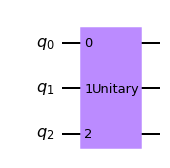

In [156]:
qc = QuantumCircuit(N)
qc.unitary(U_w,[i for i in range(N)])
qc.draw('mpl')

## For transpile, we will choose the basis gates as $Rz, CNOT$ and $H$

In [157]:
trans_qc = transpile(qc, basis_gates = ['id', 'rz', 'cx','h'], optimization_level = 1)
#trans_qc.draw('mpl')

### Writing $1$ and $2$ qubit gates as human readable format.
The following loop puts the gates in a text file.

In [158]:
## (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.9817477042468101]),
#[Qubit(QuantumRegister(3, 'q'), 0)], [])

## (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'q'), 0)], [])

## (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
#[Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 0)], [])

f = trans_qc
def List_Gates(Gate_Number):
    
    
    ## The list will hold string along with the angles in case of u3.
    l = []
    
    Name_of_Gate = []
    
    ## The list will hold the qubit in case of u3.
    Qubit = []    
    
    ## The list will hold the numerical value (float) of the angle in case of u3.
    Angle = []

    ## The following two lines will be used to separate the numerical value of the angle from 
    # a mixture of string and digits.
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ )?'
    
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    
    if str(trans_qc[Gate_Number][0]).split(',')[0][-3:-1] == 'rz':
        
        Name_of_Gate.append('rz')        
        ## For the gate rz, there is one angle. The following lines puts the string which contain
        # the angle along with other alphabets in a list l.
        l.append(str(list(f)[Gate_Number]).split(',')[3])

        
        ## The following loop extracts the angle from the string of alphabet and digit.
        for i in l:
            
            if rx.findall(i) == []:
                
                ## the angle zero is written as 0.0 .
                Angle.append(0.0)
                
            else:
                
                Angle.append(float(rx.findall(i)[0]))
                
        ## the qubit on which rz acts is listed.        
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))  
        
    # For hadamard gates the qubit it is applied to is listed.    
    elif str(trans_qc[Gate_Number][0]).split(',')[0][-2:-1] == 'h':
        
        Name_of_Gate.append('h')
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))
    
    
        ## if the gate is cx then the Angle list is empty.        
    else:
        
        Name_of_Gate.append('cx')     
        ## the control and the target bit is listed.
        Control_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][0]).split(',')[2])
        
        Target_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][1]).split(',')[2])   
        
        Qubit.append([Control_bit, Target_bit])
    
    
    return Name_of_Gate,Angle, Qubit



# The following list has all the gates in the format [name of the gate, angle, qubit].
l = []
for i in range(len(f)):
    l.append(List_Gates(i))      

## To view the gates, open the following text file.    
file = open('gates_list.txt', 'w')


# The following variables will count number of each gates.
rz_count = 0
h_count = 0
cx_count = 0


## The following loop writes the gates into the file.
for i in range(len(l)):
    
    if l[i][0][0] == 'rz':
        
        file.write('rz'+','+str(l[i][1][0])+','+str(l[i][2][0])+','+'\n')
        
        rz_count += 1
        
    elif l[i][0][0] == 'h':
        
        file.write('h'+','+'0.0'+','+str(l[i][2][0])+','+'\n')
        
        h_count += 1
        
    else:
        
        file.write('cx'+','+l[i][2][0][0]+','+l[i][2][0][1]+','+'\n')
        
        cx_count += 1

print(
    'Total gates used = ',len(l),'\n' \
      'Number of Rz gates =', rz_count,'\n'\
      'Number of Hadamard gates =', h_count,'\n'\
      'Number of CNOT gates =', cx_count
        )   
Rz_Number = rz_count

Total gates used =  250 
Number of Rz gates = 188 
Number of Hadamard gates = 42 
Number of CNOT gates = 20


## The basis gates
The following returns the matrix of the Hadamard, CNOT and RZ gate.

### Hadamard gate

In [159]:
## The dimension of the matrix is fixed by the number of qubits.
def Hadamard(Qubit):
    
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.h(Qubit)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ)

### CNOT gate

In [160]:
## The dimension of the matrix is fixed by the number of qubits.
def CNOT(t,c):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.cx(t,c)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ) 

### RZ gate

In [161]:
def Rz(Angle, Qubit):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.rz(Angle, Qubit)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ)     

## Reconstruction of the Oracle matrix from the transpile
The following multiplys the one and two qubits to get the Oracle $U_w$. This part is not required for the overall functioning of the code.

In [162]:
def Uw_NoNoise():
    
    ## Initializing the oracle U_w as an identity matrix.
    
    Or = np.identity(2**N, dtype = complex) 

    ## In the following loop we multiply all the 1 and 2 qubit gates with (or without) noise.
    
    
    for i in range(len(l)): # l is the list with all the gates.
    
        if l[i][0][0] == 'rz':
            
            Or = np.matmul(Or, Rz(float(l[i][1][0]), int(l[i][2][0])))
        
        elif l[i][0][0] == 'h':
        
            Or = np.matmul(Or, Hadamard(int(l[i][2][0])))
        
        else:
        
            Or = np.matmul(Or, CNOT(int(l[i][2][0][0]), int(l[i][2][0][1])))
     
    Or = Or/Or[0,0]
    
    if np.sign(Or[0,0]) == np.sign(U_w[0,0]):
        
        pass
    
    else:
        
        Or = -Or

    return Or

### Comparison of the Oracle $U_w$ before and after the transpile

In [183]:
print('Oiginal Oracle \n\n', U_w.real, '\n\n Oracle from transpile \n\n', np.around(Uw_NoNoise(),4).real)

Oiginal Oracle 

 [[-1. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0.]
 [-0. -0.  1. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -1.]] 

 Oracle from transpile 

 [[-1.  0. -0.  0.  0. -0. -0.  0.]
 [-0. -1. -0. -0. -0. -0.  0. -0.]
 [-0. -0.  1. -0. -0. -0.  0. -0.]
 [-0.  0. -0. -1.  0. -0. -0.  0.]
 [-0. -0. -0.  0. -1.  0. -0.  0.]
 [-0.  0.  0.  0. -0. -1.  0. -0.]
 [-0. -0.  0.  0.  0. -0. -1. -0.]
 [ 0. -0. -0. -0. -0.  0.  0. -1.]]


## Adding noise to the Oracle

### Noise creation
This following line creates an array of random numbers which length is equal to the number of Rz gates.
$$\delta = [\delta_1, \delta_2, ..., \delta_{\text{Number of Rz}}]$$
Where $\delta_i$ are random numbers between $-1$ and $1$.  

In [163]:
Rz_Noise = 2*(np.random.rand(Rz_Number)-0.5)

# Use the line below for no noise case.
#Rz_Noise = np.zeros(Rz_Number)

In the following $\epsilon$ acts as a strength of noise. The array Rz_Noise has random numbers from -1 to 1. The following function multiplies $\epsilon$ to each random numbers in Rz_Noise and add that to each Rz gate of the oracle $U_w$. We will first reconstruct the Grover operator by first constructing the oracle $U_w$ from the transpile and then by multiplying $U_w$ and $U_s$ to get $G$.

In [164]:
def Grover_reconstructed(epsilon):
    
    ## Initializing the oracle U_w as an identity matrix.
    
    Or = np.identity(2**N, dtype = complex) 

    ## In the following loop we multiply all the 1 and 2 qubit gates with (or without) noise.
    
    j = 0 # Index for the random noise list.
    
    for i in range(len(l)): # l is the list with all the gates.
    
        if l[i][0][0] == 'rz':
            
            Or = np.matmul(Or, Rz(float(l[i][1][0])  + epsilon * Rz_Noise[j], int(l[i][2][0])))
            
            j = j + 1
        
        elif l[i][0][0] == 'h':
        
            Or = np.matmul(Or, Hadamard(int(l[i][2][0])))
        
        else:
        
            Or = np.matmul(Or, CNOT(int(l[i][2][0][0]), int(l[i][2][0][1])))
     
    ## In the following we will fix the phase of the reconstructed Oracle. First we will make all the elements
    # 1 or -1.
    Or = Or/Or[0,0]
    
    ## The sign of the reconstructed Oracle should be same as that of original U_w.
    if np.sign(Or[0,0]) == np.sign(U_w[0,0]):
        
        pass # If the sign is same, then pass.
    
    else:
        
        Or = -Or # Otherwise change the sign.
    Gr = np.matmul(Or, U_s) ## The Grover operator G = U_w * U_s.
    
    return Gr

### Comparison of the Grover operator $G$ before and after and the transpile

In [188]:
print('Original Grover operator\n\n', G.real,'\n\n Grover after transpile \n\n', 
      np.around(Grover_reconstructed(0).real,2))

Original Grover operator

 [[ 0.75 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]
 [-0.25  0.75 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]
 [ 0.25  0.25 -0.75  0.25  0.25  0.25  0.25  0.25]
 [-0.25 -0.25 -0.25  0.75 -0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25  0.75 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25  0.75 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25  0.75 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25  0.75]] 

 Grover after transpile 

 [[ 0.75 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]
 [-0.25  0.75 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]
 [ 0.25  0.25 -0.75  0.25  0.25  0.25  0.25  0.25]
 [-0.25 -0.25 -0.25  0.75 -0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25  0.75 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25  0.75 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25  0.75 -0.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25  0.75]]


## Diagnonalization of G
The following code puts G in the form $G = V e^{-i \phi_F} V^{\dagger}$, where $V$ is unitary and $\phi_F$ is a diagonal matrix.

In [165]:
import numpy
import numpy.linalg

sigma_x=numpy.zeros((2,2),dtype=complex)
sigma_y=numpy.zeros((2,2),dtype=complex)
sigma_z=numpy.zeros((2,2),dtype=complex)
sigma_0=numpy.identity(2,dtype=complex)
sigma_x[0,1]=1.
sigma_x[1,0]=1.
sigma_y[0,1]=-1.j
sigma_y[1,0]=1.j
sigma_z[0,0]=1.
sigma_z[1,1]=-1.
sigma_plus=(sigma_x+1.j*sigma_y)/2.
sigma_minus=(sigma_x-1.j*sigma_y)/2.

def adjoint(psi):
    return psi.conjugate().transpose()

def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())

def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))

def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))

def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns

def comm(a,b):
    return a.dot(b)-b.dot(a)

def anti_comm(a,b):
    return a.dot(b)+b.dot(a)

def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol

def is_unitary(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol

def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)

    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))

    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger



### Checking that $V$ is unitary

In [166]:
V = eigu(G)[1]

# Hermitian conjugate of V.
V_d = (np.conjugate(V)).transpose()

In [167]:
print('V * V^\dagger = \n\n', np.around(np.matmul(V, V_d),4))

V * V^\dagger = 

 [[ 1.+0.j -0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j  1.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j  0.+0.j  1.+0.j  0.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  1.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j -0.+0.j  1.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.+0.j  0.+0.j -0.+0.j  1.+0.j]]


### $\phi_F$ from $U_d$
Given $U_d$ by the function eigu, this function returns an array $\phi_F$.
$$V e^{-i \phi_F} V^{\dagger} = V U_d V^{\dagger}$$ so, $$e^{-i \phi_F} = U_d$$ or $$ \phi_F = i \log(U_d) $$
The following function returns and array vector $\phi_F$ for an operator as input.


In [168]:
def Phi_F(operator): 
    
    return (1j*np.log(eigu(operator)[0])).real  # eigu(Gr)[0] = exp(-i * phi_F).

### $\phi_F$ of the constructed Grover operator without noise

In [169]:
np.around(Phi_F(Grover_reconstructed(0)),8)

array([ 2.41885841,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -2.41885841])

### $\phi_F$ of the original Grover operator

In [170]:
Phi_F(G)

array([ 2.41885841, -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        , -2.41885841])

## Ploting the graph

In [110]:
f = open('quantum_data.txt', 'w')
Num = 20
for i in range(1,Num):
    eps = i/(4* Num)
    f = open('quantum_data.txt', 'a')
    for j in range(2**N):
        f.write(str(eps)+','+str(Phi_F(Grover_reconstructed(eps))[j].real)+'\n')
    f.close()    

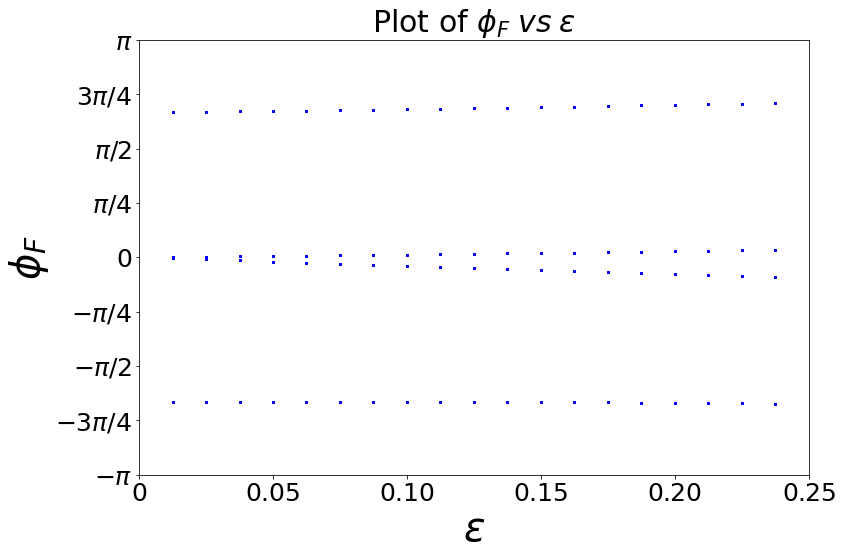

Time taken 0.17272828817367553 minutes


In [111]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.loadtxt('quantum_data.txt', delimiter = ',', unpack=True)
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.scatter(X, Y ,s=5, c='b', marker ='s')
plt.title(r'Plot of $\phi_F \; vs \;  \epsilon$', fontsize = 30)
#plt.title('Phi_F vs. epsilon',fontsize=30)
plt.xlabel(r'$\epsilon$',fontsize=40)
plt.xticks(fontsize=25)
plt.ylabel(r'$\phi_F$',fontsize=40)
plt.yticks(fontsize=25)
plt.xticks([0, 0.05, 0.10, 0.15, 0.20, 0.25],
          ['$0$', '$0.05$', '$0.10$', '$0.15$', '$0.20$', '$0.25$' ])
plt.yticks([-pi, -pi/2, -3*pi/4, -pi/4, 0, pi/4, 3*pi/4, pi/2, pi],
           ['$-\pi$', r'$-\pi/2$', r'$-3\pi/4$', r'$-\pi/4$', r'$0$', r'$\pi/4$', r'$3\pi/4$',
            r'$\pi/2$', '$\pi$' ])
plt.savefig("Images/" + Target_state + "-"  +str(Num)+".pdf")
plt.show()
end = time.time()
print('Time taken', (end-start)/60,'minutes')